# Project NLP | Business Case: Automated Customer Reviews

In [56]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the dataset
data = pd.read_csv('data/1429_1.csv')

# Inspect the first few rows of the data
print("Data Head:")
print(data.head())

# Check for any missing values
print("Missing Values in Data:")
print(data.isnull().sum())

# Display basic statistics for the data
print("Data Statistics:")
print(data.describe())

# Display columns to understand the structure
print("Data Columns:")
print(data.columns)



Data Head:
                     id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
3  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
4  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   

        asins   brand                                         categories  \
0  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
1  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
2  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
3  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
4  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   

                                                keys manufactur

C:\Users\jaime\AppData\Local\Temp\ipykernel_32820\1852819308.py:7: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/1429_1.csv')


## Drop unecessary columns

In [57]:
# Columns to drop
columns_to_drop = [
    'id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 
    'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 
    'reviews.id', 'reviews.sourceURLs', 'reviews.userCity', 'reviews.userProvince', 'reviews.username'
]

# Drop the columns
data_cleaned = data.drop(columns=columns_to_drop)

# Rename columns

data_cleaned.columns = data_cleaned.columns.str.replace('reviews.', '', regex=False)

# Display columns to confirm the drop
print("Data Columns After Dropping:")
print(data_cleaned.columns)


Data Columns After Dropping:
Index(['doRecommend', 'numHelpful', 'rating', 'text', 'title'], dtype='object')


## Check for missing values

In [58]:
# Check for any missing values
print("Missing Values in Data:")
print(data_cleaned.isnull().sum())

Missing Values in Data:
doRecommend    594
numHelpful     529
rating          33
text             1
title            6
dtype: int64


## Drop rows missing text and rating

In [59]:
# Drop rows with missing 'text' and 'rating'
data_cleaned = data_cleaned.dropna(subset=['text', 'rating'])

# Check for any remaining missing values
print("Missing Values in Data After Dropping Rows:")
print(data_cleaned.isnull().sum())

Missing Values in Data After Dropping Rows:
doRecommend    560
numHelpful     495
rating           0
text             0
title            6
dtype: int64


## Plot the Distribution of Rating and doRecommend

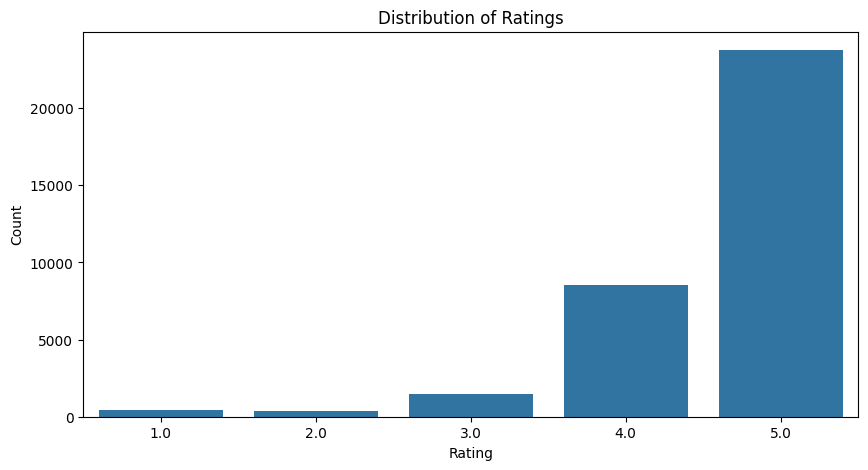

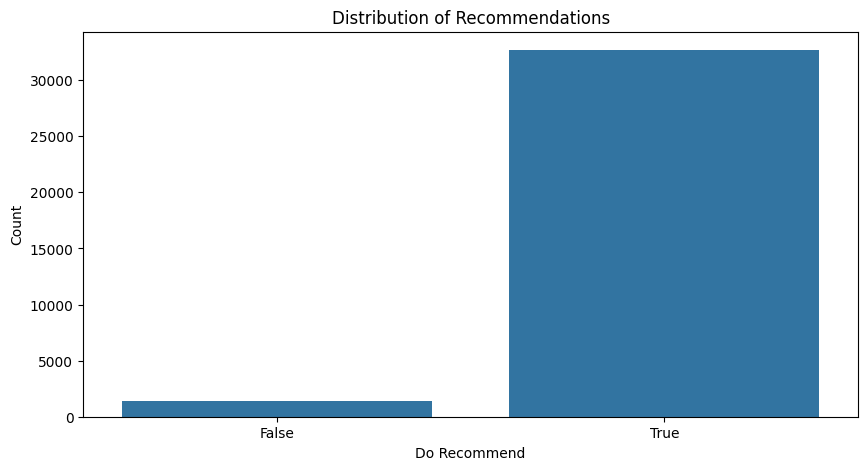

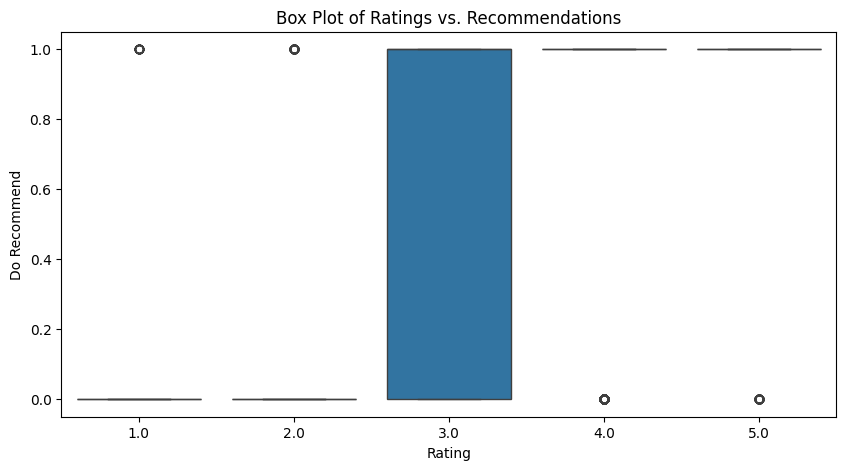

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns



# Plot the distribution of ratings
plt.figure(figsize=(10, 5))
sns.countplot(data=data_cleaned, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Plot the distribution of doRecommend
plt.figure(figsize=(10, 5))
sns.countplot(data=data_cleaned, x='doRecommend')
plt.title('Distribution of Recommendations')
plt.xlabel('Do Recommend')
plt.ylabel('Count')
plt.show()

# Joint plot to explore correlation
plt.figure(figsize=(10, 5))
sns.boxplot(x='rating', y='doRecommend', data=data_cleaned)
plt.title('Box Plot of Ratings vs. Recommendations')
plt.xlabel('Rating')
plt.ylabel('Do Recommend')
plt.show()


## Calculate Review Length

In [61]:
# Calculate the length of each review
data_cleaned['review_length'] = data_cleaned['text'].apply(len)

# Display the first few rows to confirm the new column
print(data_cleaned[['text', 'review_length']].head())


                                                text  review_length
0  This product so far has not disappointed. My c...            143
1  great for beginner or experienced person. Boug...             75
2  Inexpensive tablet for him to use and learn on...            131
3  I've had my Fire HD 8 two weeks now and I love...            593
4  I bought this for my grand daughter when she c...            613


## Correlation between review lenght and rating

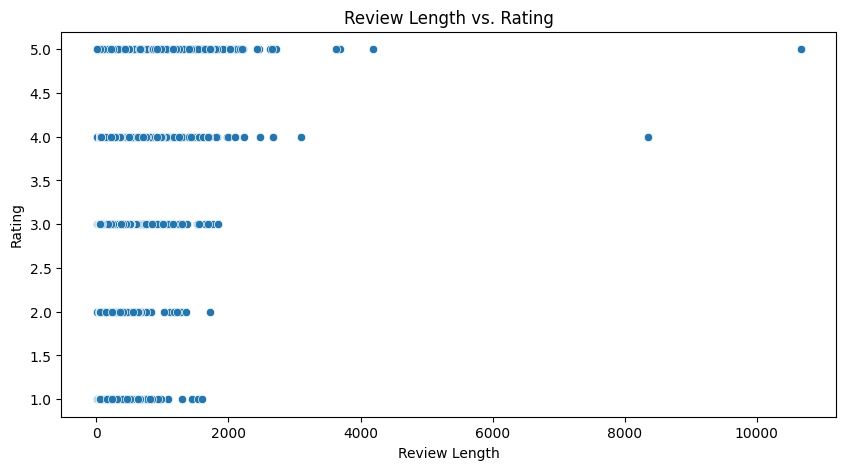

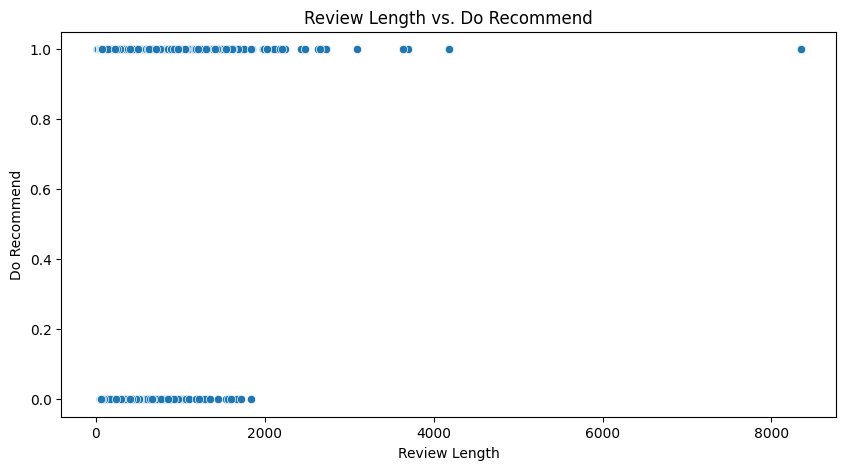

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of review length vs. rating
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data_cleaned, x='review_length', y='rating')
plt.title('Review Length vs. Rating')
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.show()

# Scatter plot of review length vs. doRecommend
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data_cleaned, x='review_length', y='doRecommend')
plt.title('Review Length vs. Do Recommend')
plt.xlabel('Review Length')
plt.ylabel('Do Recommend')
plt.show()


In [63]:
# Calculate correlation coefficient between review length and rating
correlation_rating = data_cleaned['review_length'].corr(data_cleaned['rating'])
print(f'Correlation between Review Length and Rating: {correlation_rating:.2f}')

# Calculate correlation coefficient between review length and doRecommend
correlation_doRecommend = data_cleaned['review_length'].corr(data_cleaned['doRecommend'])
print(f'Correlation between Review Length and Do Recommend: {correlation_doRecommend:.2f}')


Correlation between Review Length and Rating: -0.11
Correlation between Review Length and Do Recommend: -0.09


## encode ratings into positive (2), neutral (1), negative (0)

   rating  sentiment
0     5.0          2
1     5.0          2
2     5.0          2
3     4.0          2
4     5.0          2
Distribution of Rating Categories:
sentiment
2    32315
1     1499
0      812
Name: count, dtype: int64


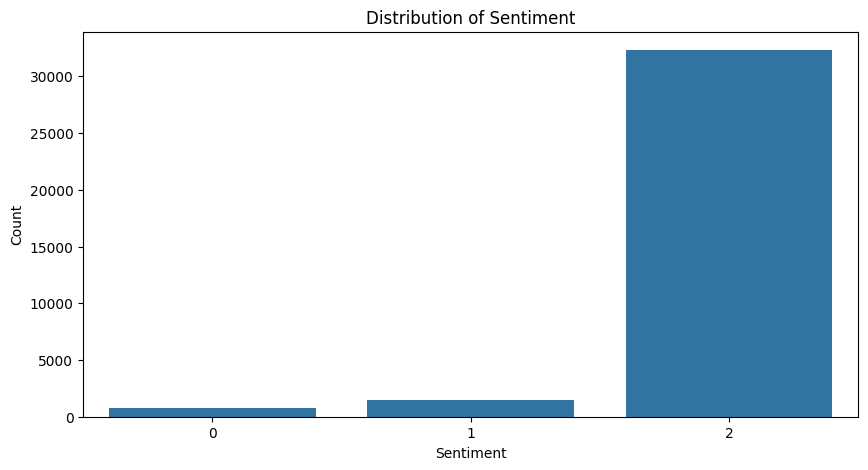

In [64]:
# Function to categorize ratings
def categorize_rating(rating):
    if rating in [4, 5]:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

# Apply the function to the rating column
data_cleaned['sentiment'] = data_cleaned['rating'].apply(categorize_rating)

# Display the first few rows to confirm the new column
print(data_cleaned[['rating', 'sentiment']].head())

# Check the distribution of the new categories
print("Distribution of Rating Categories:")
print(data_cleaned['sentiment'].value_counts())

# Plot the distribution of Sentiment
plt.figure(figsize=(10, 5))
sns.countplot(data=data_cleaned, x='sentiment')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Word clouds

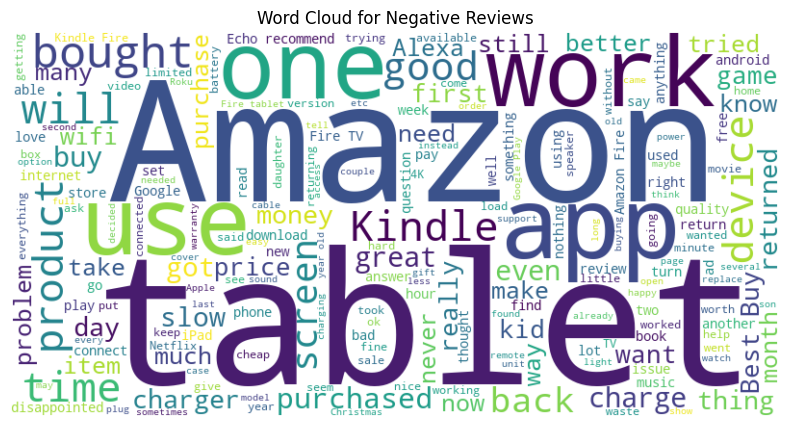

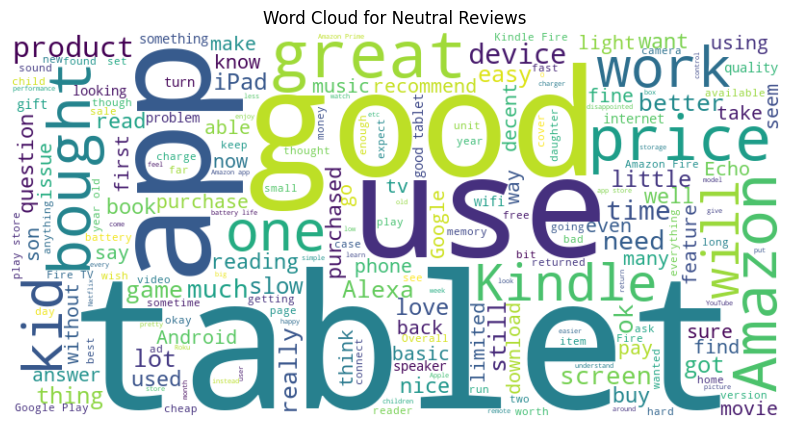

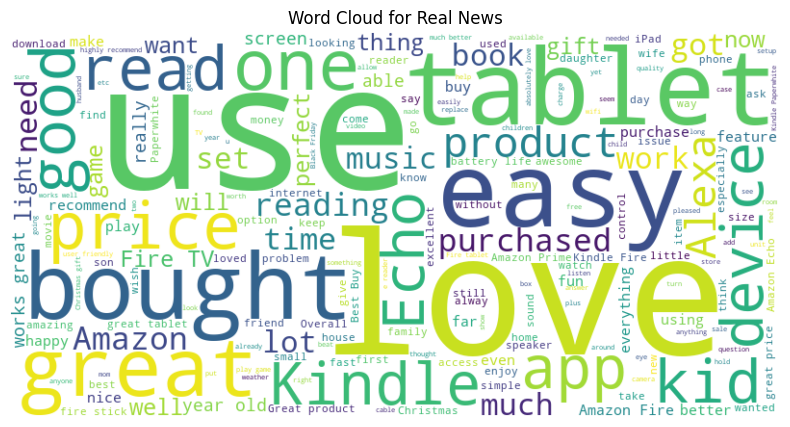

In [73]:
from wordcloud import WordCloud

# Generate word clouds
negative = ' '.join(data_cleaned[data_cleaned['sentiment'] == 0]['text'])
neutral = ' '.join(data_cleaned[data_cleaned['sentiment'] == 1]['text'])
positive = ' '.join(data_cleaned[data_cleaned['sentiment'] == 2]['text'])

# Word cloud for negatige reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


# Word cloud for neutral reviews
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Reviews')
plt.show()

# Word cloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

## Data Cleaning (Lowercase, Remove Stopwords, Lemmatization)

In [74]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE


# Download NLTK stopwords and WordNet data if not already done
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Define additional stop words 
additional_stop_words = {'tablet', 'amazon', 'kindle', 'product', 'bought', 'purchase', 'device', 'one', 'use', 'would', 'app', 'alexa', 'fire', 'echo', 'game'}


# Define the preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    stop_words = set(stopwords.words('english')).union(additional_stop_words)
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatization
    return text

# Apply preprocessing
data_cleaned['cleaned_text'] = data_cleaned['text'].apply(preprocess_text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Split the data into training and testing sets

In [75]:
from sklearn.model_selection import train_test_split


# Feature matrix (X) and target vector (Y)
X = data_cleaned['cleaned_text']
Y = data_cleaned['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Vectorization

In [76]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Resampling

In [77]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Confirm the resampling
print("Original training set class distribution:")
print(y_train.value_counts())
print("\nResampled training set class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Original training set class distribution:
sentiment
2    25824
1     1221
0      655
Name: count, dtype: int64

Resampled training set class distribution:
sentiment
2    25824
1    25824
0    25824
Name: count, dtype: int64


## Train and Evaluate models

In [80]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

# Train and evaluate models
def train_and_evaluate_models(X_train_resampled, y_train_resampled, X_test_vectorized, y_test):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
    }
    
    for name, model in models.items():
        print(f'\nTraining {name}...')
        model.fit(X_train_resampled, y_train_resampled)
        print(f'Evaluating {name}...')
        evaluate_model(model, X_test_vectorized, y_test)


In [81]:
# Train and evaluate models
train_and_evaluate_models(X_train_resampled, y_train_resampled, X_test_vectorized, y_test)



Training Random Forest...
Evaluating Random Forest...
Accuracy: 0.93
Precision: 0.90
Recall: 0.93
F1 Score: 0.91
Confusion Matrix:
[[  10    7  140]
 [   6   18  254]
 [   8   48 6435]]
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.06      0.11       157
           1       0.25      0.06      0.10       278
           2       0.94      0.99      0.97      6491

    accuracy                           0.93      6926
   macro avg       0.54      0.37      0.39      6926
weighted avg       0.90      0.93      0.91      6926


Training Gradient Boosting...
Evaluating Gradient Boosting...
Accuracy: 0.82
Precision: 0.92
Recall: 0.82
F1 Score: 0.86
Confusion Matrix:
[[  70   33   54]
 [  43  116  119]
 [ 253  769 5469]]
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.45      0.27       157
           1       0.13      0.42      0.19       278
           2       0.97     